# GAN
Train a GAN on the MNIST handwritten digit dataset. 

This makes use of: our custom Keras model class defined in vaegan.gan.py, our
class for loading the MNIST dataset defined in vaegan.data, and our custom Keras
callback in vaegan.callbacks.

A directory called 'output' will be created to save figures and the trained
model.  

In [1]:
nEpochs=40  # orig, longer training
#nEpochs=3  # quick testing during development

In [2]:
!nvidia-smi

Wed May 28 11:56:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:02:00.0 Off |                    0 |
| N/A   24C    P0             24W /  250W |      19MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Import 3rd party libraries 

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload



2025-05-28 11:56:46.531081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748451406.811510   31721 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748451406.914015   31721 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748451407.425620   31721 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748451407.425664   31721 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748451407.425667   31721 computation_placer.cc:177] computation placer alr

## 2. Import our own classes (that we will complete together)

In [4]:
# Import our own classes 
from vaegan.data import MNIST
from vaegan.callbacks import GenerateImages
import vaegan.gan


## 3. Show some our data

I0000 00:00:1748451419.339844   31721 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15506 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 6.0
/project/nanocourse/SWE_OOP/train11/Module_2_Materials/04_ExerciseCodeAndInstructions/vaegan/vaegan/data.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


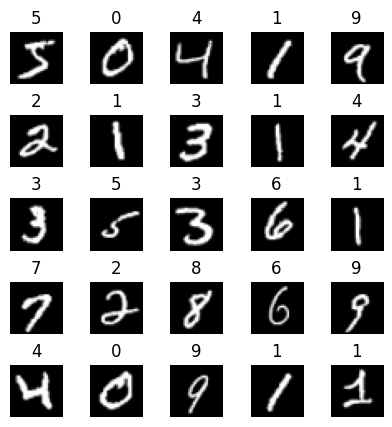

In [5]:
# Create output directory if it doesn't exist yet.
output_dir = './outputs/mnist_gan'
os.makedirs(output_dir, exist_ok=True)
    
# Instantiate the MNIST class containing our training data.
data = MNIST()

# Show some example images and their labels.
data.show_example_images(os.path.join(output_dir, 'example_images.png'))

## 4. Construct the model using the python class you completed

In [6]:
pyModule = reload(vaegan.gan)


# Create the model. Note that we're using mostly the default arguments, but this is
# where you might want to play around with different loss weights.
tf.random.set_seed(1234)
model = pyModule.GAN()

# This step tells Keras to compute the explicit output shapes of each layer.
# Otherwise, the layers will have dynamic/variable output shapes which is not
# compatible with saving and loading.
model.compute_output_shape((None, 32, 32, 1))
model.discriminator.compute_output_shape((None, 32, 32, 1))

Loaded version: vaegan.gan


TensorShape([None, 1])

## <span style="color:blue"> Correct model dimensions </span>
    

<span style="color:blue"> === OVERALL MODEL ==== </span>

```
Model: "gan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
generator (Generator)        multiple                  1582465   
_________________________________________________________________
discriminator (Discriminator multiple                  50145     
_________________________________________________________________
gen_loss (Mean)              multiple                  2         
_________________________________________________________________
disc_loss (Mean)             multiple                  2         
=================================================================
Total params: 1,632,614
Trainable params: 1,632,418
Non-trainable params: 196
_________________________________________________________________

```
<span style="color:blue"> === GENERATOR SUBMODEL ====</span>
```
Layer (type)                 Output Shape              Param #   
=================================================================
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
relu_dense (LeakyReLU)       (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv0 (Conv2DTranspose)      (None, 16, 16, 128)       262272    
_________________________________________________________________
relu0 (LeakyReLU)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv1 (Conv2DTranspose)      (None, 32, 32, 128)       262272    
_________________________________________________________________
relu1 (LeakyReLU)            (None, 32, 32, 128)       0         
_________________________________________________________________
conv_out (Conv2D)            (None, 32, 32, 1)         1153      
_________________________________________________________________
sigmoid_out (Activation)     (None, 32, 32, 1)         0         
=================================================================
Total params: 1,582,465
Trainable params: 1,582,465
Non-trainable params: 0

```
<span style="color:blue"> === DISCRIMINATOR SUBMODEL ====</span>
```
Layer (type)                 Output Shape              Param #   
=================================================================
input_12 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 32, 32, 32)        544       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 32, 32, 32)        128       
_________________________________________________________________
relu0 (ReLU)                 (None, 32, 32, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 64)        32832     
_________________________________________________________________
bn1 (BatchNormalization)     (None, 16, 16, 64)        256       
_________________________________________________________________
relu1 (ReLU)                 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense_out (Dense)            (None, 1)                 16385     
_________________________________________________________________
sigmoid_out (Activation)     (None, 1)                 0         
=================================================================
Total params: 50,145
Trainable params: 49,953
Non-trainable params: 192

```
## 5. Now check your model's  dimensions against this list above

In [7]:
print("=== OVERALL MODEL ====")
model.summary()
print("=== GENERATOR SUBMODEL ====")
gen_in = tf.keras.layers.Input(model.n_latent_dims)
gen_out  = model.generator.call(gen_in) 
gen = tf.keras.Model(gen_in, gen_out) 
gen.summary()
print("=== DISCRIMINATOR SUBMODEL ====")
disc_in = tf.keras.layers.Input(model.image_shape) 
disc_out  = model.discriminator.call(disc_in) 
disc = tf.keras.Model(disc_in, disc_out) 
disc.summary()

=== OVERALL MODEL ====
Model: "gan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 generator (Generator)       multiple                  1582465   
                                                                 
 discriminator (Discriminat  (None, 1)                 50145     
 or)                                                             
                                                                 
Total params: 1632614 (6.23 MB)
Trainable params: 1632418 (6.23 MB)
Non-trainable params: 196 (784.00 Byte)
_________________________________________________________________
=== GENERATOR SUBMODEL ====
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense (Dense)       

## 6. Compile the model 

In [8]:
# Compile the model with an optimizer. The learning rate of the optimizer can be
# specified here. Normally, this is also where you would select a loss function
# and any metrics. However, our custom model defines the loss functions inside
# its __init__ constructor, so we don't need to do that here. 
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001))

# Instantiate our custom callback to save a few example reconstructions and
# generated images after each epoch.
save_images_callback = GenerateImages(output_dir=output_dir, 
                                      model=model,
                                      n_generated_images=10,
                                      n_latent_dims=model.n_latent_dims)

# the number of latent dims is 128
# model.build(input_shape=(60000, 32, 32, 1))

## 7. Train (fit) the model on the data  

In [9]:
# Train the model. Just like any off-the-shelf Keras model, we just call fit.
# Under the hood, Keras will call the train_step method of our custom subclass
# on each mini-batch and automatically loop through the training data. It will
# take care of all the details, like converting numpy arrays to tensors, showing
# a progress bar, and tracking the loss over the epochs.
logs = model.fit(data.images_train,
                 batch_size=128,
                 epochs=nEpochs,
                 callbacks=[save_images_callback])

# 469 is the number of iterations/epoch...

Epoch 1/40


I0000 00:00:1748451425.346901   32125 cuda_dnn.cc:529] Loaded cuDNN version 90300


469/469 [==============================] - 33s 58ms/step - loss_gen: 1.1315 - loss_disc: 0.0208
Epoch 2/40
469/469 [==============================] - 26s 56ms/step - loss_gen: 13.7502 - loss_disc: 0.0365
Epoch 3/40
469/469 [==============================] - 26s 56ms/step - loss_gen: 5.3587 - loss_disc: 0.0177
Epoch 4/40
469/469 [==============================] - 26s 56ms/step - loss_gen: 13.1975 - loss_disc: 0.0119
Epoch 5/40
469/469 [==============================] - 26s 56ms/step - loss_gen: 8.3631 - loss_disc: 0.0147
Epoch 6/40
469/469 [==============================] - 26s 56ms/step - loss_gen: 0.8897 - loss_disc: 0.0074
Epoch 7/40
469/469 [==============================] - 26s 56ms/step - loss_gen: 6.5074 - loss_disc: 0.0128
Epoch 8/40
469/469 [==============================] - 26s 56ms/step - loss_gen: 4.6753 - loss_disc: 0.0209
Epoch 9/40
469/469 [==============================] - 26s 56ms/step - loss_gen: 8.8795 - loss_disc: 0.0025
Epoch 10/40
469/469 [=========================

## 8. Training saves results to disk, now also plot training curves

INFO:tensorflow:Assets written to: ./outputs/mnist_gan/gan/assets


INFO:tensorflow:Assets written to: ./outputs/mnist_gan/gan/assets


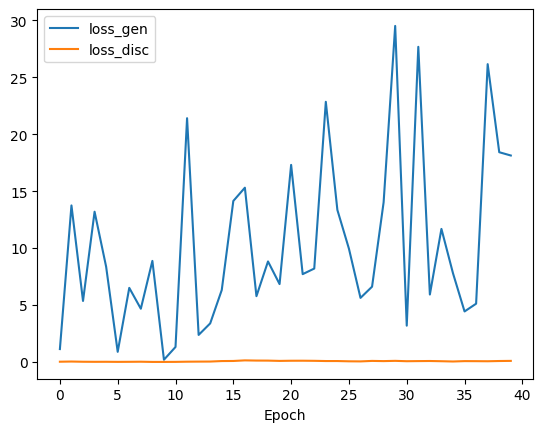

In [10]:
# Plot the training curves, which are stored in logs.history as a dict. Keys of
# this dict are the metric names, while the corresponding values are arrays.
fig, ax = plt.subplots()

for loss_name in ['loss_gen', 'loss_disc']:
    loss_values = logs.history[loss_name]
    x = np.arange(len(loss_values))
    ax.plot(x, loss_values, label=loss_name)
    
ax.legend()
ax.set_xlabel('Epoch')
fig.savefig(os.path.join(output_dir, 'training_curves.png'), transparent=False)
# fig.show()

# Save the model 
model.save(os.path.join(output_dir, 'gan'))